In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np
import pickle
random.seed(14)

def show_null(df):
    print("num null values\n")
    for col_name,i in zip(df.columns,df.isnull().sum()):
        print(f'{col_name}:{i}/{len(df)}')
    print("\n")
    

df=pd.read_csv("/home/vk/personal/time-series/time_series_15min_singleindex.csv")

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'])
df.tail()

/tmp/ipykernel_29728/2840244380.py:23: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'])


,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,...,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
201599,2020-09-30 22:45:00+00:00,2020-10-01 00:45:00+02:00,5482.4,5284.0,NaN,NaN,1740.0,7916.55,8105.94,46229.48,...,NaN,157.28,384.36,382.0,12324.95,12094.02,NaN,908.51,640.25,268.26
201600,2020-09-30 23:00:00+00:00,2020-10-01 01:00:00+02:00,5464.0,5272.0,NaN,NaN,1712.0,7912.79,8025.29,45792.82,...,NaN,153.32,382.41,371.0,12218.53,11950.22,NaN,925.15,669.88,255.27
201601,2020-09-30 23:15:00+00:00,2020-10-01 01:15:00+02:00,5390.4,5200.0,NaN,NaN,1672.0,7818.72,7931.56,45471.18,...,NaN,147.56,378.74,368.0,12076.92,11832.26,NaN,975.34,719.18,256.16
201602,2020-09-30 23:30:00+00:00,2020-10-01 01:30:00+02:00,5329.2,5140.0,NaN,NaN,1600.0,7780.18,7872.25,45119.89,...,NaN,137.19,375.86,369.0,11929.69,11717.22,NaN,976.64,721.50,255.14
201603,2020-09-30 23:45:00+00:00,2020-10-01 01:45:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df=df.loc[:,['utc_timestamp','DE_load_actual_entsoe_transparency','DE_load_forecast_entsoe_transparency']]
df.tail()

,utc_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency
201599,2020-09-30 22:45:00+00:00,46229.48,45971.68
201600,2020-09-30 23:00:00+00:00,45792.82,45303.45
201601,2020-09-30 23:15:00+00:00,45471.18,44987.77
201602,2020-09-30 23:30:00+00:00,45119.89,44668.15
201603,2020-09-30 23:45:00+00:00,NaN,NaN


In [3]:
show_null(df)
df=df.dropna()
show_null(df)

num null values

utc_timestamp:0/201604
DE_load_actual_entsoe_transparency:6/201604
DE_load_forecast_entsoe_transparency:102/201604


num null values

utc_timestamp:0/201502
DE_load_actual_entsoe_transparency:0/201502
DE_load_forecast_entsoe_transparency:0/201502




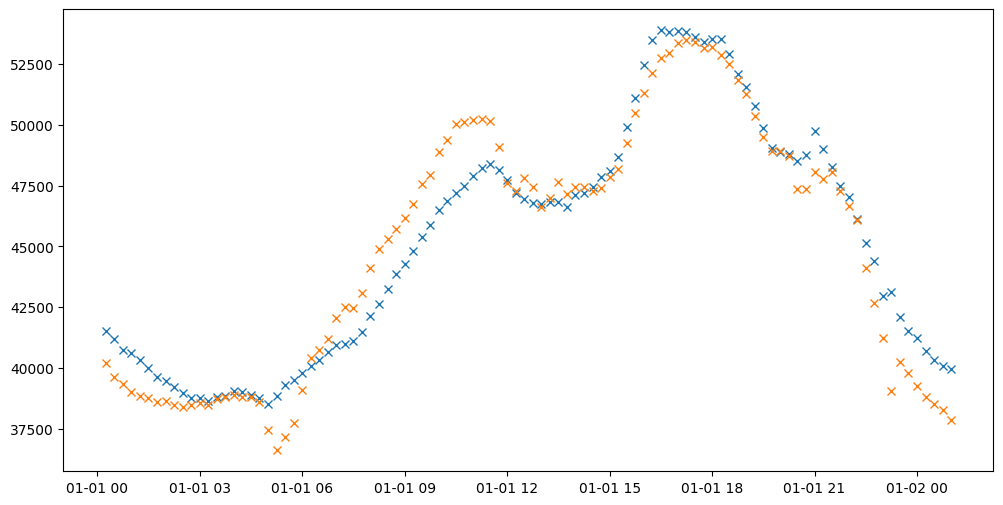

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['utc_timestamp'][:100],df.loc[:,['DE_load_actual_entsoe_transparency','DE_load_forecast_entsoe_transparency']][:100],'x')
plt.show()

In [5]:
df['year'] = [i.year for i in df['utc_timestamp']]
df['month'] = [i.month for i in df['utc_timestamp']]
df['day'] = [i.day for i in df['utc_timestamp']]
df['hour'] = [i.hour for i in df['utc_timestamp']]
df['minute'] = [i.minute for i in df['utc_timestamp']]
df['day_of_week'] = [i.day_of_week for i in df['utc_timestamp']]

lags = [1, 2, 4]  # 15 min, 30 min, 1 hr, 2 hrs, 3 hrs, 4 hrs, 1 day, 1 week
for lag in lags:
    df[f'lag_{lag}'] = df["DE_load_actual_entsoe_transparency"].shift(lag)
    
df['rolling_mean_1hr'] = df["DE_load_actual_entsoe_transparency"].rolling(window=4).mean()
df['rolling_std_1hr'] = df["DE_load_actual_entsoe_transparency"].rolling(window=4).std()
df['diff_1hr'] = df["DE_load_actual_entsoe_transparency"].diff(periods=4)


df.tail()
df.dropna(inplace=True)
show_null(df)
df.corr()

num null values

utc_timestamp:0/201498
DE_load_actual_entsoe_transparency:0/201498
DE_load_forecast_entsoe_transparency:0/201498
year:0/201498
month:0/201498
day:0/201498
hour:0/201498
minute:0/201498
day_of_week:0/201498
lag_1:0/201498
lag_2:0/201498
lag_4:0/201498
rolling_mean_1hr:0/201498
rolling_std_1hr:0/201498
diff_1hr:0/201498




,utc_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,year,month,day,hour,minute,day_of_week,lag_1,lag_2,lag_4,rolling_mean_1hr,rolling_std_1hr,diff_1hr
utc_timestamp,1.000000,-0.026934,-0.009316,0.985433,0.078485,0.015491,0.000391,-3.852609e-06,-0.001339,-0.026913,-0.026892,-0.026851,-2.698237e-02,-0.028391,-3.172661e-04
DE_load_actual_entsoe_transparency,-0.026934,1.000000,0.978208,-0.015619,-0.067049,-0.009161,0.153008,-2.060988e-03,-0.396991,0.997316,0.990468,0.965613,9.948428e-01,0.025504,1.310829e-01
DE_load_forecast_entsoe_transparency,-0.009316,0.978208,1.000000,0.002699,-0.071912,-0.002343,0.158467,-1.837602e-03,-0.356940,0.975966,0.969447,0.944824,9.735255e-01,0.015110,1.272553e-01
year,0.985433,-0.015619,0.002699,1.000000,-0.091577,-0.000618,-0.000071,-2.003547e-05,-0.001642,-0.015620,-0.015621,-0.015623,-1.566651e-02,-0.029550,1.638083e-05
month,0.078485,-0.067049,-0.071912,-0.091577,1.000000,0.009569,-0.000070,-1.572687e-05,0.002020,-0.067033,-0.067016,-0.066977,-6.722280e-02,0.006642,-2.699233e-04
day,0.015491,-0.009161,-0.002343,-0.000618,0.009569,1.000000,-0.000074,-2.194465e-05,-0.002543,-0.009067,-0.008971,-0.008768,-9.043824e-03,-0.000101,-1.498618e-03
hour,0.000391,0.153008,0.158467,-0.000071,-0.000070,-0.000074,1.000000,-2.116204e-05,-0.000185,0.191938,0.229589,0.300333,2.107083e-01,0.059999,-5.617828e-01
minute,-0.000004,-0.002061,-0.001838,-0.000020,-0.000016,-0.000022,-0.000021,1.000000e+00,0.000003,0.000407,0.000815,-0.002061,-6.420682e-07,-0.023753,7.428425e-07
day_of_week,-0.001339,-0.396991,-0.356940,-0.001642,0.002020,-0.002543,-0.000185,3.330125e-06,1.000000,-0.395552,-0.394081,-0.391021,-3.959718e-01,-0.115376,-2.274833e-02
lag_1,-0.026913,0.997316,0.975966,-0.015620,-0.067033,-0.009067,0.191938,4.069644e-04,-0.395552,1.000000,0.997316,0.979803,9.992341e-01,0.001207,6.673812e-02


In [6]:
df.tail()

,utc_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,year,month,day,hour,minute,day_of_week,lag_1,lag_2,lag_4,rolling_mean_1hr,rolling_std_1hr,diff_1hr
201598,2020-09-30 22:30:00+00:00,46505.50,46360.69,2020,9,30,22,30,2,47110.02,47699.71,49282.64,47513.5375,951.347894,-2777.14
201599,2020-09-30 22:45:00+00:00,46229.48,45971.68,2020,9,30,22,45,2,46505.50,47110.02,48738.92,46886.1775,655.262685,-2509.44
201600,2020-09-30 23:00:00+00:00,45792.82,45303.45,2020,9,30,23,0,2,46229.48,46505.50,47699.71,46409.4550,551.557094,-1906.89
201601,2020-09-30 23:15:00+00:00,45471.18,44987.77,2020,9,30,23,15,2,45792.82,46229.48,47110.02,45999.7450,458.535788,-1638.84
201602,2020-09-30 23:30:00+00:00,45119.89,44668.15,2020,9,30,23,30,2,45471.18,45792.82,46505.50,45653.3425,472.279274,-1385.61


In [ ]:
feature_col_names=['lag_'+str(i) for i in lags]+['diff_1hr','rolling_mean_1hr','rolling_std_1hr','minute','hour','day_of_week','month','year']
features=df.loc[:,feature_col_names]
# features=df.loc[:,['lag_1','lag_3','lag_7','hour','day_of_week','day','month']]
labels=df['DE_load_actual_entsoe_transparency']

train_features,val_features,train_labels,val_labels = train_test_split(features,labels, test_size=0.2, shuffle=False)

In [ ]:
len(train_features),len(train_labels),len(val_features),len(val_labels)

In [ ]:
#model=LinearRegression()
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=400)
model.fit(train_features,train_labels)

In [ ]:
val_forecasted=model.predict(val_features)
val_mae=mean_absolute_error(val_labels,val_forecasted)
print(f"Validation MAE: {val_mae:.2f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(100)],val_labels[:100],color='red')
plt.plot([i for i in range(100)],val_forecasted[:100],color='blue')
plt.show()

In [ ]:
test_df=pd.read_csv("/home/vk/personal/time-series/test-de-load-2025.csv")
test_df['Time (CET/CEST)']=[i.split('-')[0] for i in test_df['Time (CET/CEST)']]
#test_df['Time (CET/CEST)']=pd.to_datetime(test_df['Time (CET/CEST)'],format="%m.%d.%Y %H:%M ")
test_df['Time (CET/CEST)']=pd.to_datetime(test_df['Time (CET/CEST)'],format="%d.%m.%Y %H:%M ")
test_df['year'] = [i.year for i in test_df['Time (CET/CEST)']]
test_df['month'] = [i.month for i in test_df['Time (CET/CEST)']]
test_df['day'] = [i.month for i in test_df['Time (CET/CEST)']]
test_df['hour'] = [i.hour for i in test_df['Time (CET/CEST)']]
test_df['minute'] = [i.minute for i in test_df['Time (CET/CEST)']]
test_df['day_of_week'] = [i.day_of_week for i in test_df['Time (CET/CEST)']]
test_df['rolling_mean_1hr'] = test_df["Actual Total Load [MW] - BZN|DE-LU"].rolling(window=4).mean()
test_df['rolling_std_1hr'] = test_df["Actual Total Load [MW] - BZN|DE-LU"].rolling(window=4).std()
test_df['diff_1hr'] = test_df["Actual Total Load [MW] - BZN|DE-LU"].diff(periods=4)

for lag in lags:
    test_df[f'lag_{lag}'] = test_df["Actual Total Load [MW] - BZN|DE-LU"].shift(lag)
test_df.tail()
test_df.dropna(inplace=True)
show_null(test_df)
test_df.head()

In [ ]:
test_features=test_df.loc[:,feature_col_names]
test_labels=test_df['Actual Total Load [MW] - BZN|DE-LU']
test_forecasted=model.predict(test_features)
test_mae=mean_absolute_error(test_labels,test_forecasted)
print(f"Test MAE: {test_mae:.2f}")

#Test MAE: 197.21

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in test_df.index],test_labels,color='red')
plt.plot([i for i in test_df.index],test_forecasted,color='blue')
plt.show()

In [ ]:
with open("DE_LU_load_prediction_xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
print('Actual','Forecasted','Diff','Time')

for i,label,pred in zip(test_df.index,test_labels,test_forecasted):
    
    if abs(label-pred)>1000:
        print(label,int(pred),int(pred-label),test_df.loc[i,['Time (CET/CEST)']][0],test_df.loc[i,['Time (CET/CEST)']][0].day)

In [ ]:
test_df

In [ ]:
mean_absolute_error(test_df["Day-ahead Total Load Forecast [MW] - BZN|DE-LU"],test_df["Actual Total Load [MW] - BZN|DE-LU"])

print('Actual','Forecasted','Diff','Time')

for i,label,pred in zip(test_df.index,test_df["Day-ahead Total Load Forecast [MW] - BZN|DE-LU"],test_df["Actual Total Load [MW] - BZN|DE-LU"]):
    
    if abs(label-pred)>1000:
        print(label,int(pred),int(pred-label),test_df.loc[i,['Time (CET/CEST)']][0],test_df.loc[i,['Time (CET/CEST)']][0].day)

In [ ]:
test_df.loc[6143:,feature_col_names]

In [ ]:
test_df.iloc[-4:,2]

In [ ]:
curr_value=test_df.iloc[-1,features]
for i in range(96):
    curr_value=model.predict(curr_value)